# Assignment #4
#### Problem #1  (To be submitted individually)

Using any two or several clustering techniques we have covered in class – determine the groups of “similar” panelist.  You will choose what set of attributes to use for determining similarity-explain why you chose them.  Provide the evaluation and validation of the produced model(s).  Describe in detail how you prepared the data, created the training data set, designed features and trained the model (what options, parameters, number of clusters, types of clustering techniques(s) used, etc.).  Compare the models produced. 


In [1]:
import h5py as h5
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, LinearSVR
from sklearn import preprocessing
import calendar as cal
import seaborn as sns
import datetime as dt
%matplotlib inline

# Clustering and Segmentation in 9 steps

1) Confirm the data in metric

2) Decide whether to scale or standardize the data

3) Decide which variables to use for clustering

4) Define similarity or dissimilarity measures between observations

5) Visualize Individual Attributes and Pair-wise Distances between the Observations

6) Select the clustering method to use and decide how many clusters to have

7) Profile and interpret the clusters

8) Assess the robustness of our clusters

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pandas import HDFStore
store = HDFStore('/Users/ryanriopelle/Documents/DSE/DSE220/yogurt.h5')
store.keys()

['/delivery_stores', '/demos', '/drug', '/groc', '/panel']

In [4]:
# We are storing the data in an HDF5 file, this makes it easy to access
path='/Users/ryanriopelle/Documents/DSE/DSE220/yogurt.h5'
data = h5.File(path)
def printname(name):   
    print(name)

data.visit(printname)

delivery_stores
delivery_stores/axis0
delivery_stores/axis1
delivery_stores/block0_items
delivery_stores/block0_values
delivery_stores/block1_items
delivery_stores/block1_values
delivery_stores/block2_items
delivery_stores/block2_values
demos
demos/axis0
demos/axis1
demos/block0_items
demos/block0_values
demos/block1_items
demos/block1_values
demos/block2_items
demos/block2_values
drug
drug/_i_table
drug/_i_table/index
drug/_i_table/index/abounds
drug/_i_table/index/bounds
drug/_i_table/index/indices
drug/_i_table/index/indicesLR
drug/_i_table/index/mbounds
drug/_i_table/index/mranges
drug/_i_table/index/ranges
drug/_i_table/index/sorted
drug/_i_table/index/sortedLR
drug/_i_table/index/zbounds
drug/table
groc
groc/_i_table
groc/_i_table/index
groc/_i_table/index/abounds
groc/_i_table/index/bounds
groc/_i_table/index/indices
groc/_i_table/index/indicesLR
groc/_i_table/index/mbounds
groc/_i_table/index/mranges
groc/_i_table/index/ranges
groc/_i_table/index/sorted
groc/_i_table/index/sort

In [5]:
# Other team members have looked at grouping on the panel data, I will look at the demographic data
path = '/Users/ryanriopelle/Documents/DSE/DSE220/yogurt.h5'
df = pd.read_hdf(path, key='panel')

In [6]:
# List is the graphic data keys so that non metric data can be used

df_demos = pd.read_hdf(path, key='demos')
df_demos.keys()

Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'COUNTY',
       u'Children Group Code', u'Combined Pre-Tax Income of HH', u'EXT_FACT',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'FIPSCODE', u'Family Size',
       u'Female Working Hour Code', u'HH_AGE', u'HH_EDU', u'HH_OCC',
       u'HH_RACE', u'IRI Geography Number', u'Language',
       u'Male Working Hour Code', u'Marital Status', u'Number of Cats',
       u'Number of Dogs', u'Occupation Code of Female HH',
       u'Occupation Code of Male HH', u'Panelist ID', u'RACE3',
       u'Type of Residential Possession', u'Year', u'ZIPCODE', u'filename',
       u'yearID'],
      dtype='object')

In [7]:
df_demos

,ALL_TVS,Age Group Applied to Female HH,Age Group Applied to Male HH,CABL_TVS,COUNTY,Children Group Code,Combined Pre-Tax Income of HH,EXT_FACT,Education Level Reached by Female HH,Education Level Reached by Male HH,...,Number of Dogs,Occupation Code of Female HH,Occupation Code of Male HH,Panelist ID,RACE3,Type of Residential Possession,Year,ZIPCODE,filename,yearID
0,3.0,6,6,3.0,NaN,8,3.0,NaN,3,2,...,0,10,10,1100016,NaN,2,2001,NaN,ads demo1.csv,1
1,NaN,5,7,NaN,NaN,3,5.0,NaN,7,9,...,0,6,11,1100032,NaN,2,2001,NaN,ads demo1.csv,1
2,NaN,6,6,NaN,NaN,8,8.0,NaN,6,5,...,1,4,10,1100057,NaN,2,2001,NaN,ads demo1.csv,1
3,1.0,6,6,1.0,NaN,8,7.0,NaN,4,4,...,0,10,10,1100156,NaN,2,2001,NaN,ads demo1.csv,1
4,NaN,6,6,NaN,NaN,8,10.0,NaN,4,5,...,1,4,1,1100164,NaN,2,2001,NaN,ads demo1.csv,1
5,2.0,5,5,2.0,NaN,8,11.0,NaN,5,5,...,1,1,7,1100180,NaN,2,2001,NaN,ads demo1.csv,1
6,NaN,6,6,NaN,NaN,8,5.0,NaN,6,5,...,0,13,10,1100198,NaN,2,2001,NaN,ads demo1.csv,1
7,3.0,3,3,1.0,NaN,4,12.0,NaN,4,4,...,3,13,6,1100206,NaN,2,2001,NaN,ads demo1.csv,1
8,NaN,5,7,NaN,NaN,8,7.0,NaN,5,9,...,1,4,11,1100214,NaN,2,2001,NaN,ads demo1.csv,1
9,NaN,6,7,NaN,NaN,8,1.0,NaN,4,9,...,0,10,11,1100222,NaN,2,2001,NaN,ads demo1.csv,1


In [8]:
# Removed the following from the dataframe 

# u'ALL_TVS' : Not necessary
# u'CABL_TVS' : Not necessary
# u'EXT_FACT' : Not metric
# u'COUNTY' : Not metric
# u'Children Group Code' : Not Metric
# u'EXT_FACT' : Not metric, don't know what this is
# u'FIPSCODE' : Wouldnt have an effect
# u'HH_OCC', : Dont know what this is
# u'Language', : Not metric
# u'Panelist ID' : Not metric
# u'filename': Not metric
# u'yearID': Not metric
# u'ZIPCODE' : don't care
# 'HH_AGE' : Null
# 'HH_EDU' : Null
# 'IRI Geography Number' : Null
# 'RACE3'
# 'Year'

demos_reduced = df_demos[['Age Group Applied to Female HH','Age Group Applied to Male HH', 'Combined Pre-Tax Income of HH',
         'Education Level Reached by Female HH',
       'Education Level Reached by Male HH', u'Family Size',
       'Female Working Hour Code',  
       'HH_RACE',  
       'Male Working Hour Code', 'Marital Status', 
       'Occupation Code of Female HH',
       'Occupation Code of Male HH', 
       'Type of Residential Possession']]
demos_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74592 entries, 0 to 4606
Data columns (total 13 columns):
Age Group Applied to Female HH          74592 non-null int64
Age Group Applied to Male HH            74592 non-null int64
Combined Pre-Tax Income of HH           74581 non-null float64
Education Level Reached by Female HH    74592 non-null int64
Education Level Reached by Male HH      74592 non-null int64
Family Size                             74592 non-null int64
Female Working Hour Code                74592 non-null int64
HH_RACE                                 74158 non-null float64
Male Working Hour Code                  74592 non-null int64
Marital Status                          74592 non-null int64
Occupation Code of Female HH            74592 non-null int64
Occupation Code of Male HH              74592 non-null int64
Type of Residential Possession          74592 non-null int64
dtypes: float64(2), int64(11)
memory usage: 8.0 MB


# Using Demographic Data

In [9]:
demos_reduced.head()

,Age Group Applied to Female HH,Age Group Applied to Male HH,Combined Pre-Tax Income of HH,Education Level Reached by Female HH,Education Level Reached by Male HH,Family Size,Female Working Hour Code,HH_RACE,Male Working Hour Code,Marital Status,Occupation Code of Female HH,Occupation Code of Male HH,Type of Residential Possession
0,6,6,3.0,3,2,3,4,1.0,4,2,10,10,2
1,5,7,5.0,7,9,2,3,1.0,5,1,6,11,2
2,6,6,8.0,6,5,2,3,1.0,4,2,4,10,2
3,6,6,7.0,4,4,2,4,1.0,4,2,10,10,2
4,6,6,10.0,4,5,2,3,1.0,3,2,4,1,2


In [13]:
#fill NaN values with mean

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputed = imp.fit_transform(demos_reduced)

#Normalize the data

normalized = preprocessing.normalize(imputed, norm='l2', axis=1, copy=True)

# Clustering Estimation For N Groups

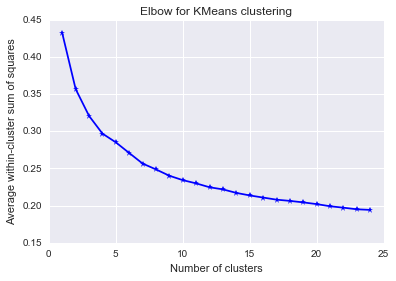

In [15]:
dt_trans = normalized

K = range(1,25)
KM = [KMeans(n_clusters=k, n_jobs=-1).fit(dt_trans) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(dt_trans, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/dt_trans.shape[0] for d in dist]

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering');

# Groups of 6 seam reasonable according to this graph

# Cluster Using Regular K-Means

In [16]:
km = KMeans(n_clusters=6, n_jobs=-1)
km.fit(imputed)
clusters = km.predict(imputed)
data = km.cluster_centers_
df_centers = pd.DataFrame(data, columns=demos_reduced.columns)
df_centers = df_centers.round(decimals=0)

In [17]:
df_centers.sort(columns=['Combined Pre-Tax Income of HH'],ascending=[0])

,Age Group Applied to Female HH,Age Group Applied to Male HH,Combined Pre-Tax Income of HH,Education Level Reached by Female HH,Education Level Reached by Male HH,Family Size,Female Working Hour Code,HH_RACE,Male Working Hour Code,Marital Status,Occupation Code of Female HH,Occupation Code of Male HH,Type of Residential Possession
1,4.0,4.0,9.0,5.0,5.0,3.0,2.0,1.0,2.0,2.0,4.0,3.0,2.0
2,4.0,4.0,8.0,99.0,99.0,2.0,99.0,1.0,99.0,1.0,99.0,99.0,1.0
0,5.0,6.0,6.0,5.0,6.0,2.0,3.0,1.0,4.0,2.0,8.0,10.0,2.0
5,6.0,5.0,6.0,3.0,10.0,2.0,3.0,2.0,9.0,3.0,59.0,99.0,1.0
3,4.0,7.0,5.0,91.0,0.0,1.0,99.0,1.0,4.0,3.0,99.0,10.0,2.0
4,5.0,6.0,5.0,3.0,1.0,2.0,3.0,1.0,3.0,3.0,99.0,9.0,1.0


In [ ]:
#df_centers.sort(columns=['Marital Status'],ascending=[0])

# Groups

0) Married Middle Aged Family With Well Educated Male (typical middle classs family)
1) Single Graduate Level Educated Who Rent (Assuming they might live in the city)
2) Divorced Middle Aged Highly Educated Women (Single Women who have not had kids yet, family size was rounded) 
3) Married Wealthy Managers with technical school experience who own a home (Upper Class)
4) Divorce Older Aged Retired 
5) Divorced Older Uneducated Who Rent

Type of Residential Possession
The type of residential possession 0 = 'N/A'
1 = 'Renter' 2 = 'Owner'

HH_EDU
0 = ‘N/A’
1 = 'Some grade school or less' 2 = 'Completed grade school'
3 = 'Some high school'
4 = 'Graduated high school'
5 = 'Technical school'
6 = 'Some college'
7 = 'Graduated from college'
8 = 'Post graduate work'
9 = 'No such head of household'


Marital Status
marital status code 0 = 'N/A'
1 = 'Single'
2 = 'Married'
3 = 'Divorced' 4 = 'Widowed' 5 = 'Separated'


Female Working Hour Code
female work hours
1 = 'Not employed'
2 = 'Part time, < 35 hrs./wk.' 3 = 'Full time, > 35 hrs./wk.' 4 = 'Retired'
5 = 'Homemaker'
6 = 'Student' 7 = 'N/A'

HH_OCC
worker'
0 = 'Other'
1 = 'Professional or technical'
2 = 'Manager or administrator'
3 = 'Sales'
4 = 'Clerical'
5 = 'Craftsman'
6 = 'Operative (machine operator)' 7 = 'Laborer'
8 = 'Cleaning, food, health service
9 = 'Private household worker' 10 = 'Retired'
11 = 'No such head of household' 13 = 'Not employed'

Combined Pre-Tax Income of HH
combined pre-tax income of the heads of household 0 = 'N/A';
1 = '$00,000 to $ 9,999 per yr' 2 = '$10,000 to $11,999 per yr' 3 = '$12,000 to $14,999 per yr' 4 = '$15,000 to $19,999 per yr' 5 = '$20,000 to $24,999 per yr' 6 = '$25,000 to $34,999 per yr' 7 = '$35,000 to $44,999 per yr' 8 = '$45,000 to $54,999 per yr' 9 = '$55,000 to $64,999 per yr' 10 = '$65,000 to $74,999 per yr' 11 = '$75,000 to $99,999 per yr'
12 = '$100,000 and greater per year'


### Define a CLassifier Based off of this

In [18]:
km.predict(imputed)

array([0, 0, 0, ..., 0, 5, 0], dtype=int32)

In [19]:
demos_predict_6C = demos_reduced
demos_predict_6C["Predicted Cluster"]=km.predict(imputed)

# We can pull out specific groups to analyze them like below

In [20]:
upper_middle_class = demos_predict_6C[demos_predict_6C['Predicted Cluster']==3]
upper_middle_class

,Age Group Applied to Female HH,Age Group Applied to Male HH,Combined Pre-Tax Income of HH,Education Level Reached by Female HH,Education Level Reached by Male HH,Family Size,Female Working Hour Code,HH_RACE,Male Working Hour Code,Marital Status,Occupation Code of Female HH,Occupation Code of Male HH,Type of Residential Possession,Predicted Cluster
32,6,6,9.0,3,3,2,99,1.0,2,1,99,8,1,3
764,2,7,5.0,99,0,1,99,1.0,4,4,99,11,2,3
786,4,5,4.0,3,3,3,99,4.0,1,4,99,4,2,3
790,4,7,2.0,99,0,1,99,1.0,4,3,99,11,2,3
793,3,3,8.0,99,5,2,99,1.0,2,1,99,1,1,3
802,3,7,4.0,99,0,1,99,1.0,4,4,99,11,2,3
823,4,2,7.0,99,3,2,99,1.0,2,4,99,8,2,3
825,4,7,8.0,99,0,1,99,1.0,4,4,99,11,2,3
838,4,7,4.0,99,0,1,99,1.0,4,4,99,11,2,3
849,2,7,6.0,99,0,1,99,1.0,4,4,99,11,2,3


In [21]:
highest_class = upper_middle_class[upper_middle_class['Combined Pre-Tax Income of HH']==12.0]
highest_class

,Age Group Applied to Female HH,Age Group Applied to Male HH,Combined Pre-Tax Income of HH,Education Level Reached by Female HH,Education Level Reached by Male HH,Family Size,Female Working Hour Code,HH_RACE,Male Working Hour Code,Marital Status,Occupation Code of Female HH,Occupation Code of Male HH,Type of Residential Possession,Predicted Cluster
2811,6,6,12.0,6,6,2,99,1.0,3,1,99,9,1,3
2459,6,6,12.0,6,6,2,99,1.0,3,1,99,9,1,3
3103,6,5,12.0,0,4,3,99,1.0,2,1,99,2,1,3
3115,3,7,12.0,99,0,1,99,1.0,4,1,99,11,1,3
1185,5,7,12.0,99,0,1,99,1.0,4,1,99,11,1,3
2362,6,6,12.0,6,6,2,99,1.0,3,1,99,9,1,3
2954,6,5,12.0,0,4,3,99,1.0,2,1,99,2,1,3
2967,3,7,12.0,99,0,1,99,1.0,4,1,99,11,1,3
2679,6,6,12.0,6,6,2,99,1.0,3,1,99,9,1,3


# Clustering Using K-Means Mini Batch


In [27]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs


mbk = MiniBatchKMeans(init='k-means++', n_clusters=6)
t0 = time.time()
mbk.fit(imputed)
t_mini_batch = time.time() - t0
mbk_means_labels = mbk.labels_
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels_unique = np.unique(mbk_means_labels)

In [40]:
df_batch_centers = pd.DataFrame(mbk_means_cluster_centers, columns=demos_reduced.columns[0:13])
df_batch_centers =  df_batch_centers.round(decimals=0)

In [41]:
df_batch_centers

,Age Group Applied to Female HH,Age Group Applied to Male HH,Combined Pre-Tax Income of HH,Education Level Reached by Female HH,Education Level Reached by Male HH,Family Size,Female Working Hour Code,HH_RACE,Male Working Hour Code,Marital Status,Occupation Code of Female HH,Occupation Code of Male HH,Type of Residential Possession
0,5.0,6.0,5.0,5.0,6.0,2.0,3.0,2.0,5.0,2.0,10.0,10.0,2.0
1,4.0,4.0,10.0,5.0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0
2,4.0,5.0,8.0,5.0,5.0,3.0,2.0,1.0,3.0,2.0,4.0,6.0,2.0
3,6.0,7.0,7.0,17.0,5.0,1.0,16.0,1.0,6.0,2.0,52.0,11.0,1.0
4,5.0,5.0,6.0,23.0,31.0,2.0,24.0,1.0,30.0,2.0,63.0,99.0,1.0
5,4.0,4.0,9.0,6.0,5.0,3.0,3.0,1.0,2.0,2.0,10.0,2.0,2.0


In [38]:
columns=demos_reduced.columns[0:13]

In [39]:
columns

Index([u'Age Group Applied to Female HH', u'Age Group Applied to Male HH',
       u'Combined Pre-Tax Income of HH',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'Family Size',
       u'Female Working Hour Code', u'HH_RACE', u'Male Working Hour Code',
       u'Marital Status', u'Occupation Code of Female HH',
       u'Occupation Code of Male HH', u'Type of Residential Possession'],
      dtype='object')

In [43]:
import numpy as np
from sklearn import mixture

# Clustering Using Gaussian Mixture Models

In [54]:
np.random.seed(1)
g = mixture.GMM(n_components=6)
# Generate random observations with two modes centered on 0
# and 10 to use for training.
obs = np.concatenate((np.random.randn(100, 1),
                      10 + np.random.randn(300, 1)))
g.fit(imputed) 
np.round(g.means_, 6)
#np.round(g.covars_, 2) 

array([[  4.625528,   6.995087,   4.825811,   4.569803,   7.150243,
          1.500605,   2.871403,   1.509867,   5.658505,   2.957416,
          6.384726,  10.984892,   1.50194 ],
       [  3.863636,   3.832168,   7.758741,  88.657343,  99.      ,
          1.958042,  89.013986,   1.202797,  99.      ,   1.643357,
         90.314685,  99.      ,   1.27972 ],
       [  4.484954,   4.363554,   7.850877,   5.129307,   4.723733,
          2.780097,   2.777158,   1.032957,   2.681789,   1.805547,
          6.024906,   5.568763,   1.646196],
       [  5.230599,   6.161863,   5.026608,   3.323725,   1.232816,
          1.986696,   2.982262,   1.286031,   3.381375,   3.133038,
         99.      ,   8.871397,   1.323725],
       [  5.801653,   5.53719 ,   5.890496,   2.944215,   4.033058,
          2.297521,   2.964876,   2.070248,   3.291322,   3.280992,
         61.508264,  99.      ,   1.247934],
       [  3.958015,   6.828244,   5.332061,  90.641221,   0.477099,
          1.160305,  98.984

In [55]:
np.round(g.weights_, 2)

array([ 0.28,  0.  ,  0.7 ,  0.01,  0.01,  0.  ])